In [7]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=af1f6d4821e1e66dca9b2dba0af578387b01c2c3c7220501f568be1d51b4b408
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


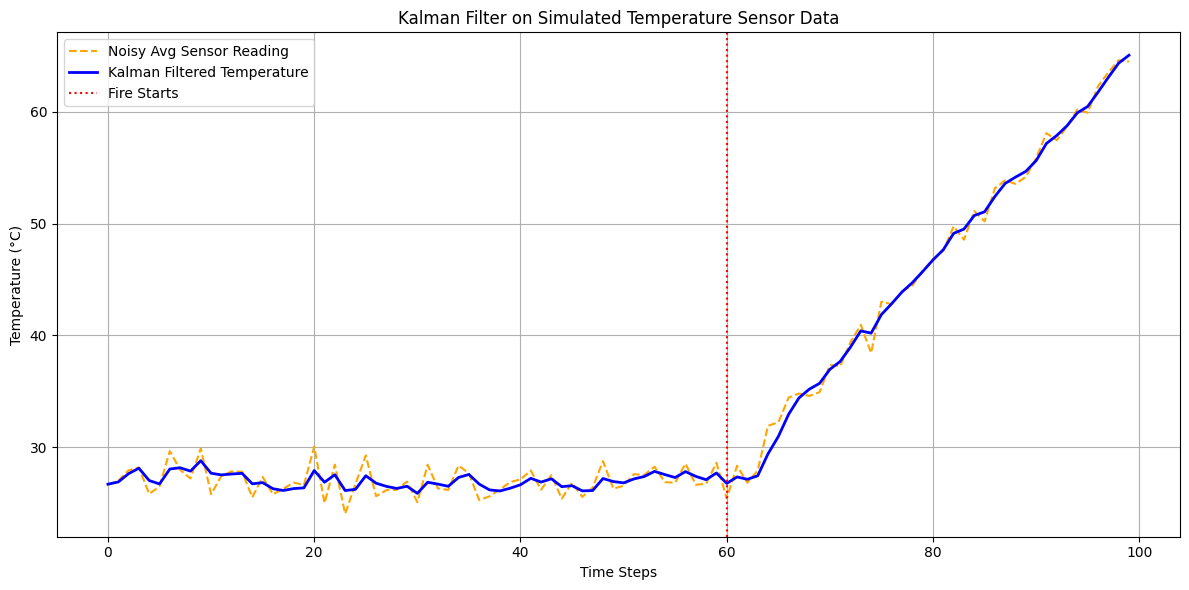

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# --- Simulation Settings ---
timesteps = 100
fire_start = 60
fire_temp = 65
baseline_temp = 27
noise_level = 2

# --- Generate Noisy Sensor Data ---
np.random.seed(42)
sensor1 = baseline_temp + np.random.normal(0, noise_level, timesteps)
sensor2 = baseline_temp + np.random.normal(0, noise_level, timesteps)
sensor3 = baseline_temp + np.random.normal(0, noise_level, timesteps)

# Simulate fire
sensor1[fire_start:] += (np.linspace(0, fire_temp - baseline_temp, timesteps - fire_start))
sensor2[fire_start:] += (np.linspace(0, fire_temp - baseline_temp, timesteps - fire_start))
sensor3[fire_start:] += (np.linspace(0, fire_temp - baseline_temp, timesteps - fire_start))

# Average sensor reading
avg_sensor = (sensor1 + sensor2 + sensor3) / 3

# --- Kalman Filter Setup ---
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([[baseline_temp], [0]])       # Initial state: temperature, rate of change
kf.F = np.array([[1, 1],
                 [0, 1]])                      # State transition matrix
kf.H = np.array([[1, 0]])                      # Measurement function
kf.P *= 10                                     # Initial uncertainty
kf.R = 4                                       # Measurement noise
kf.Q = np.array([[0.01, 0.01],
                 [0.01, 0.1]])                # Process noise

# --- Run Kalman Filter ---
filtered = []
for z in avg_sensor:
    kf.predict()
    kf.update([z])
    filtered.append(kf.x[0, 0])  # Temperature estimate

# --- Plot Results ---
plt.figure(figsize=(12, 6))
plt.plot(avg_sensor, label='Noisy Avg Sensor Reading', linestyle='--', color='orange')
plt.plot(filtered, label='Kalman Filtered Temperature', linewidth=2, color='blue')
plt.axvline(fire_start, color='red', linestyle=':', label='Fire Starts')
plt.title("Kalman Filter on Simulated Temperature Sensor Data")
plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# --- Fire Detection Based on Filtered Output ---
fire_threshold = 55
required_duration = 5
count = 0
fire_detected = False

for i, temp in enumerate(filtered):
    if temp >= fire_threshold:
        count += 1
        if count >= required_duration:
            print(f"Fire detected at time step {i}")
            fire_detected = True
            break
    else:
        count = 0

if not fire_detected:
    print("No fire detected")


Fire detected at time step 94


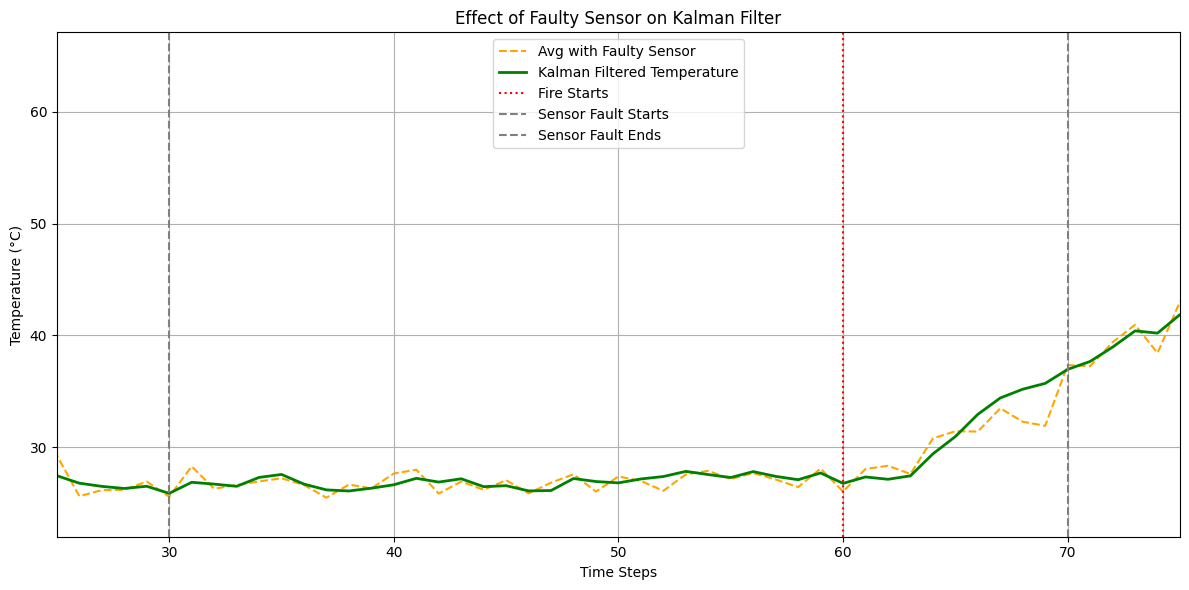

In [10]:
# --- Faulty Sensor Simulation ---
sensor3_faulty = sensor3.copy()
sensor3_faulty[30:70] = baseline_temp  # stuck at base value

# New average with faulty sensor
avg_sensor_faulty = (sensor1 + sensor2 + sensor3_faulty) / 3

# Rerun Kalman Filter with faulty average input
kf.x = np.array([[baseline_temp], [0]])  # Reset state
filtered_faulty = []
for z in avg_sensor_faulty:
    kf.predict()
    kf.update([z])
    filtered_faulty.append(kf.x[0, 0])

# Plot new comparison
plt.figure(figsize=(12, 6))
plt.plot(avg_sensor_faulty, label='Avg with Faulty Sensor', linestyle='--', color='orange')
#plt.plot(avg_sensor, label='Noisy Avg Sensor Reading', linestyle='--', color='red')
#plt.plot(filtered_faulty, label='Kalman Output with Faulty Sensor', color='blue')
plt.plot(filtered, label='Kalman Filtered Temperature', linewidth=2, color='green')
plt.axvline(fire_start, color='red', linestyle=':', label='Fire Starts')
plt.axvline(30, color='gray', linestyle='--', label='Sensor Fault Starts')
plt.axvline(70, color='gray', linestyle='--', label='Sensor Fault Ends')
plt.title("Effect of Faulty Sensor on Kalman Filter")
plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(25, 75)  # Adjust range based on your temperature profile
plt.show()


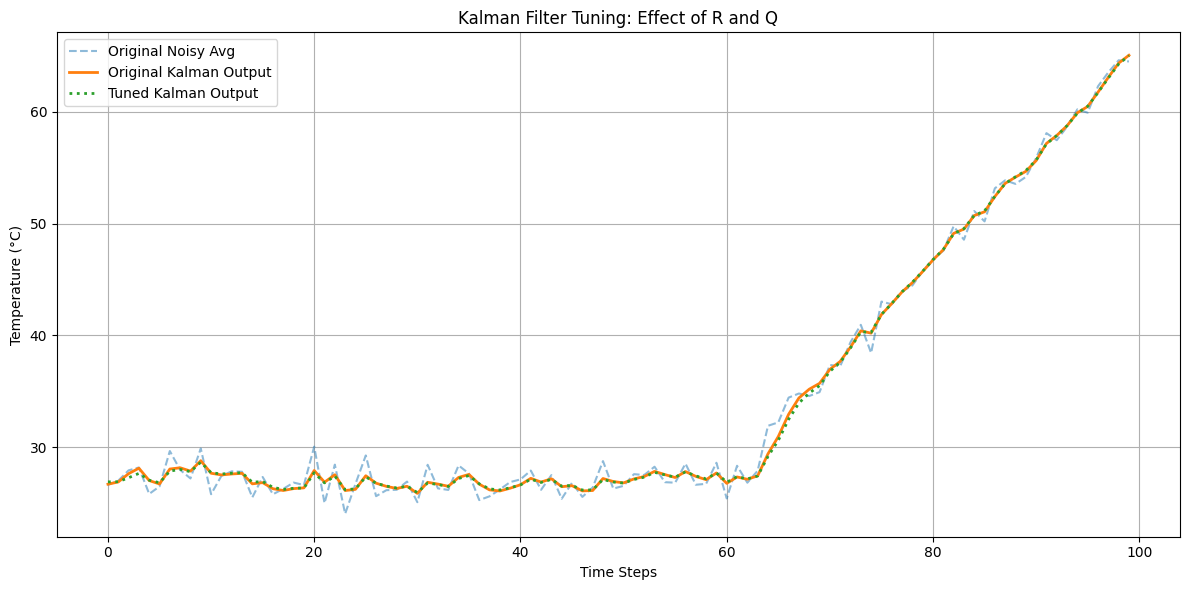

In [11]:
# --- Kalman Sensitivity Test ---
kf.R = 8  # Increase measurement noise (less trust in sensor)
kf.Q = np.array([[0.1, 0.01],
                 [0.01, 0.1]])  # More trust in model

kf.x = np.array([[baseline_temp], [0]])
filtered_tuned = []
for z in avg_sensor:
    kf.predict()
    kf.update([z])
    filtered_tuned.append(kf.x[0, 0])

# Plot for comparison
plt.figure(figsize=(12, 6))
plt.plot(avg_sensor, label='Original Noisy Avg', linestyle='--', alpha=0.5)
plt.plot(filtered, label='Original Kalman Output', linewidth=2)
plt.plot(filtered_tuned, label='Tuned Kalman Output', linestyle=':', linewidth=2)
plt.title("Kalman Filter Tuning: Effect of R and Q")
plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def evaluate_filter(true_temp, filtered_temp, label=""):
    mae = mean_absolute_error(true_temp, filtered_temp)
    rmse = sqrt(mean_squared_error(true_temp, filtered_temp))
    print(f"\nEvaluation for {label}")
    print(f"MAE  = {mae:.4f} °C")
    print(f"MSE = {rmse:.4f} °C")


In [13]:
# Ideal true temp (no noise, ground truth)
true_temp = np.ones(timesteps) * baseline_temp
true_temp[fire_start:] = np.linspace(baseline_temp, fire_temp, timesteps - fire_start)

# Evaluate all three:
evaluate_filter(true_temp, filtered, label="Original Kalman")
evaluate_filter(true_temp, filtered_faulty, label="With Faulty Sensor")
evaluate_filter(true_temp, filtered_tuned, label="Tuned Kalman Filter")



Evaluation for Original Kalman
MAE  = 0.5021 °C
MSE = 0.6481 °C

Evaluation for With Faulty Sensor
MAE  = 0.5468 °C
MSE = 0.7373 °C

Evaluation for Tuned Kalman Filter
MAE  = 0.4667 °C
MSE = 0.6179 °C


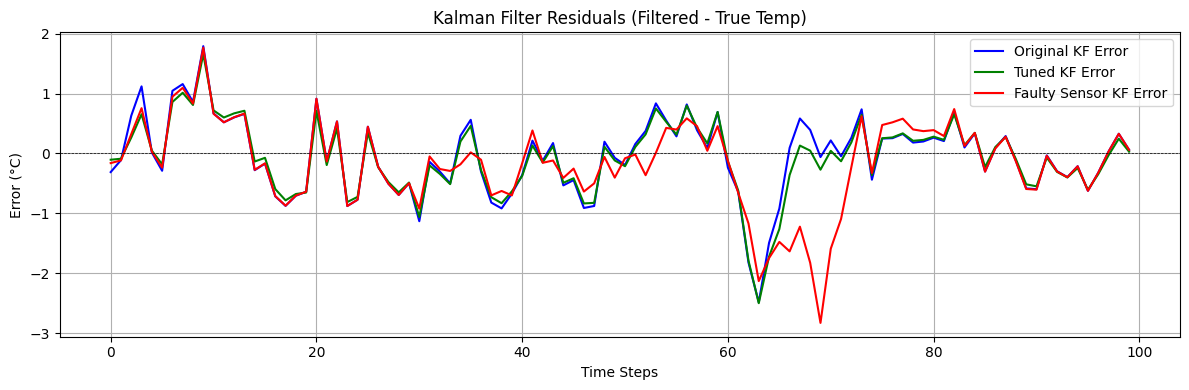

In [14]:
errors_original = filtered - true_temp
errors_tuned = filtered_tuned - true_temp
errors_faulty = filtered_faulty - true_temp

plt.figure(figsize=(12, 4))
plt.plot(errors_original, label='Original KF Error', color='blue')
plt.plot(errors_tuned, label='Tuned KF Error', color='green')
plt.plot(errors_faulty, label='Faulty Sensor KF Error', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.title("Kalman Filter Residuals (Filtered - True Temp)")
plt.xlabel("Time Steps")
plt.ylabel("Error (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

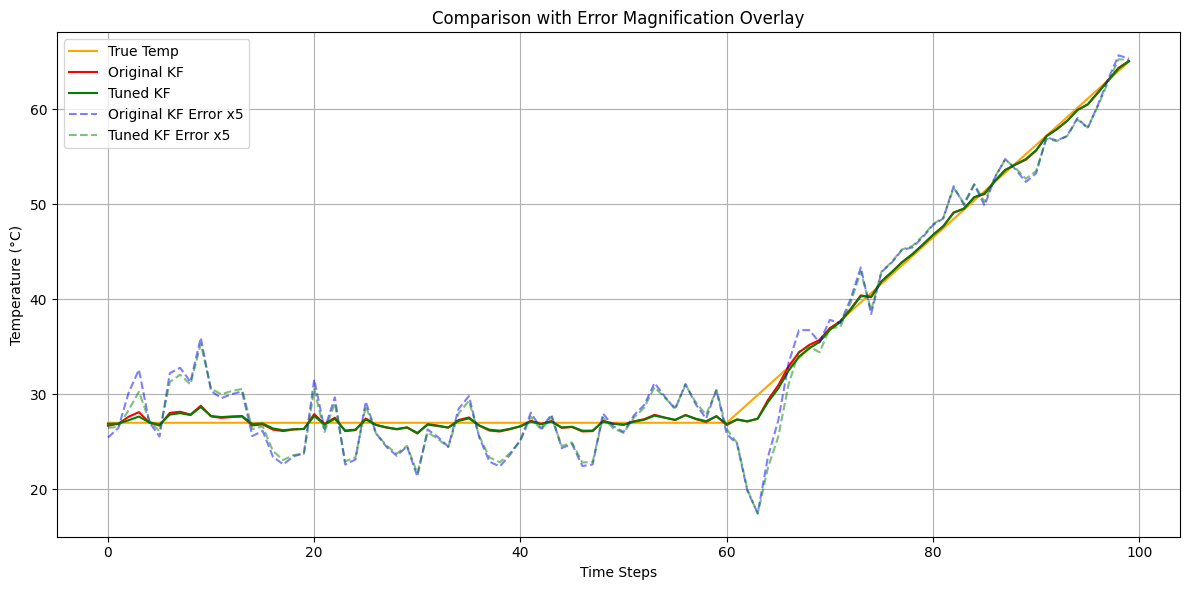

In [15]:
mag = 5  # magnification factor

plt.figure(figsize=(12, 6))
plt.plot(true_temp, label='True Temp', color='orange')
plt.plot(filtered, label='Original KF', color='red')
plt.plot(filtered_tuned, label='Tuned KF', color='green')

# Overlay errors magnified
plt.plot(true_temp + mag * (filtered - true_temp),
         label=f'Original KF Error x{mag}', linestyle='--', alpha=0.5, color='blue')
plt.plot(true_temp + mag * (filtered_tuned - true_temp),
         label=f'Tuned KF Error x{mag}', linestyle='--', alpha=0.5, color='green')

plt.title("Comparison with Error Magnification Overlay")
plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ENERGY

In [16]:
!pip install simpy plotly prettytable seaborn

In [17]:
import simpy
import numpy as np
import plotly.graph_objs as go
from prettytable import PrettyTable
import seaborn as sns
import matplotlib.pyplot as plt

# Power states (A), Voltage constant
VOLTAGE = 3.3
C_SLEEP = 2e-6
C_SENSE = 6e-3
C_ALERT = 20e-3

FIRE_TIME = 620
SAMPLE_INTERVAL = 5
SIM_DURATION = 1000

# Data containers
log = []
energy_grid = np.zeros((3, SIM_DURATION))  # [sleep, sense, alert]
table = PrettyTable(["Time", "State", "Duration (s)", "Power (mW)", "Energy (mWh)"])
states = {0: ("SLEEP", C_SLEEP), 1: ("SENSE", C_SENSE), 2: ("ALERT", C_ALERT)}

def node(env):
    total_energy = 0
    while True:
        if env.now >= FIRE_TIME:
            state = 2  # ALERT
            duration = 1
        elif (env.now % SAMPLE_INTERVAL) == (SAMPLE_INTERVAL - 1):
            state = 1  # SENSE
            duration = 1
        else:
            state = 0  # SLEEP
            duration = 1

        power = states[state][1] * VOLTAGE * 1000  # mW
        energy = (power * duration) / 3600  # mWh

        log.append((env.now, state, power, energy))
        energy_grid[state, env.now] = energy
        table.add_row([env.now, states[state][0], duration, f"{power:.2f}", f"{energy:.5f}"])

        total_energy += energy
        yield env.timeout(duration)

        if state == 2:
            break

    print(table)
    print(f"\n🔋 Total Energy Used: {total_energy:.3f} mWh")
    print(f"⏱️ Detection Delay: {FIRE_TIME % SAMPLE_INTERVAL:.2f} seconds")

# Run it
env = simpy.Environment()
env.process(node(env))
env.run(until=SIM_DURATION)


+------+-------+--------------+------------+--------------+
| Time | State | Duration (s) | Power (mW) | Energy (mWh) |
+------+-------+--------------+------------+--------------+
|  0   | SLEEP |      1       |    0.01    |   0.00000    |
|  1   | SLEEP |      1       |    0.01    |   0.00000    |
|  2   | SLEEP |      1       |    0.01    |   0.00000    |
|  3   | SLEEP |      1       |    0.01    |   0.00000    |
|  4   | SENSE |      1       |   19.80    |   0.00550    |
|  5   | SLEEP |      1       |    0.01    |   0.00000    |
|  6   | SLEEP |      1       |    0.01    |   0.00000    |
|  7   | SLEEP |      1       |    0.01    |   0.00000    |
|  8   | SLEEP |      1       |    0.01    |   0.00000    |
|  9   | SENSE |      1       |   19.80    |   0.00550    |
|  10  | SLEEP |      1       |    0.01    |   0.00000    |
|  11  | SLEEP |      1       |    0.01    |   0.00000    |
|  12  | SLEEP |      1       |    0.01    |   0.00000    |
|  13  | SLEEP |      1       |    0.01 

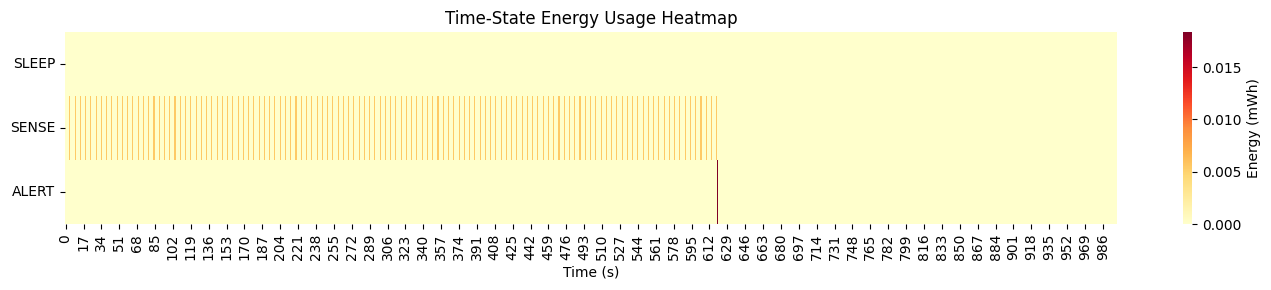

In [18]:
plt.figure(figsize=(14, 3))
sns.heatmap(energy_grid, cmap="YlOrRd", cbar_kws={'label': 'Energy (mWh)'})
plt.yticks([0.5,1.5,2.5], ["SLEEP", "SENSE", "ALERT"], rotation=0)
plt.xlabel("Time (s)")
plt.title("Time-State Energy Usage Heatmap")
plt.tight_layout()
plt.show()

In [19]:
import numpy as np

# System Parameters
FIRE_TIME = 600  # fire occurs at 600 seconds
SIMULATION_DURATION = 1000  # total simulation time
SAMPLING_INTERVAL = 10  # WoF samples every 10 seconds

# Power consumption per state (Watts)
POWER_SLEEP = 0.0001
POWER_SENSE = 0.01
POWER_ALERT = 0.05

# Duration of each state (seconds)
SENSE_DURATION = 1
ALERT_DURATION = SIMULATION_DURATION - FIRE_TIME

def compute_energy(state_times, power_levels):
    """
    state_times: list of (start_time, duration) per state
    power_levels: dict mapping state name -> power in Watts
    returns total energy used in mWh
    """
    total_energy_wh = 0
    for state, (duration, power) in state_times.items():
        total_energy_wh += (duration * power) / 3600
    return total_energy_wh * 1000  # convert Wh to mWh

# --- 1. Always-On System ---
# Always sensing until fire, then alert
always_on_states = {
    "SENSE": (FIRE_TIME, POWER_SENSE),
    "ALERT": (ALERT_DURATION, POWER_ALERT)
}
always_on_energy = compute_energy(always_on_states, None)

# --- 2. Wake-on-Fire (WoF) System ---
sense_cycles = FIRE_TIME // SAMPLING_INTERVAL
wof_sense_time = sense_cycles * SENSE_DURATION
wof_sleep_time = FIRE_TIME - wof_sense_time

wof_states = {
    "SLEEP": (wof_sleep_time, POWER_SLEEP),
    "SENSE": (wof_sense_time, POWER_SENSE),
    "ALERT": (ALERT_DURATION, POWER_ALERT)
}
wof_energy = compute_energy(wof_states, None)

# --- Results ---
print("Energy Usage Comparison")
print(f"Always-On System: {always_on_energy:.2f} mWh")
print(f"Wake-on-Fire System: {wof_energy:.2f} mWh")
print(f"Energy Saved: {always_on_energy - wof_energy:.2f} mWh ({(1 - wof_energy / always_on_energy)*100:.2f}% reduction)")

Energy Usage Comparison
Always-On System: 7.22 mWh
Wake-on-Fire System: 5.74 mWh
Energy Saved: 1.48 mWh (20.56% reduction)


In [20]:
import plotly.graph_objs as go
import numpy as np

# Recalculate in case not already available
time = np.arange(SIM_DURATION)
total_energy_per_time = energy_grid.sum(axis=0) * 1000  # Convert to µWh

fig = go.Figure()

# Wake-on-Fire trace
fig.add_trace(go.Scatter(
    x=time,
    y=total_energy_per_time,
    mode='lines',
    name='Wake-on-Fire',
    line=dict(color='firebrick', width=2),
    fill='tozeroy',
    fillcolor='rgba(255, 69, 0, 0.5)'
))

# Always-On reference line
fig.add_trace(go.Scatter(
    x=[0, SIM_DURATION - 1],
    y=[7.22, 7.22],
    mode='lines',
    name='Always-On',
    line=dict(color='dodgerblue', dash='dash')
))

fig.update_layout(
    title="Energy Consumption Over Time - Wake-on-Fire vs Always-On",
    xaxis_title="Time (s)",
    yaxis_title="Energy (mWh)",
    template="plotly_white",
    showlegend=True
)

fig.show()

NETWORK

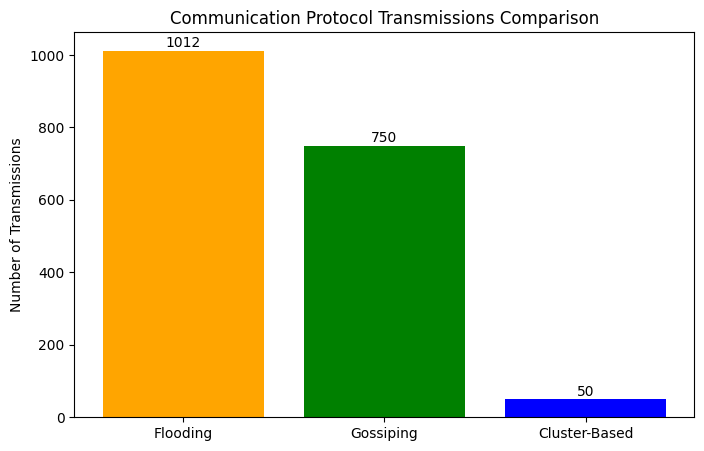

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

# Parameters
NUM_NODES = 100
COMM_RANGE = 0.2
AREA_SIZE = 1.0
FIRE_SOURCE = 0
ENERGY_PER_TX = 1

# Random 2D node positions
positions = np.random.rand(NUM_NODES, 2)
distances = distance_matrix(positions, positions)
adjacency = distances < COMM_RANGE

# --- 1. Flooding ---
def simulate_flooding():
    alerted = set([FIRE_SOURCE])
    frontier = set([FIRE_SOURCE])
    energy_used = 0

    while frontier:
        new_frontier = set()
        for node in frontier:
            neighbors = np.where(adjacency[node])[0]
            for nbr in neighbors:
                energy_used += ENERGY_PER_TX
                if nbr not in alerted:
                    alerted.add(nbr)
                    new_frontier.add(nbr)
        frontier = new_frontier
    return energy_used

# --- 2. Gossiping ---
def simulate_gossiping():
    alerted = set([FIRE_SOURCE])
    pending = [FIRE_SOURCE]
    energy_used = 0

    while len(alerted) < NUM_NODES:
        node = np.random.choice(pending)
        neighbors = np.where(adjacency[node])[0]
        if len(neighbors) == 0:
            continue
        target = np.random.choice(neighbors)
        energy_used += ENERGY_PER_TX
        if target not in alerted:
            alerted.add(target)
            pending.append(target)
    return energy_used

# --- 3. Cluster-Based ---
def simulate_cluster_based():
    # Pick cluster heads
    num_clusters = 5
    cluster_heads = np.random.choice(NUM_NODES, num_clusters, replace=False)
    energy_used = 0
    alerted = set()

    # Alert all cluster heads
    for head in cluster_heads:
        energy_used += ENERGY_PER_TX
        alerted.add(head)

    # Each head alerts nearby nodes
    for head in cluster_heads:
        neighbors = np.where(adjacency[head])[0]
        for nbr in neighbors:
            energy_used += ENERGY_PER_TX
            alerted.add(nbr)

    return energy_used

# Run simulations
flooding_energy = simulate_flooding()
gossiping_energy = simulate_gossiping()
cluster_energy = simulate_cluster_based()

# Show results
protocols = ['Flooding', 'Gossiping', 'Cluster-Based']
energy_values = [flooding_energy, gossiping_energy, cluster_energy]

plt.figure(figsize=(8, 5))
plt.bar(protocols, energy_values, color=['orange', 'green', 'blue'])
plt.ylabel("Number of Transmissions")
plt.title("Communication Protocol Transmissions Comparison")
for i, val in enumerate(energy_values):
    plt.text(i, val + 1, f"{val:.0f}", ha='center', va='bottom')
plt.show()

In [22]:
import networkx as nx
import numpy as np
import pandas as pd
import random

# Simulation parameters
NUM_NODES = 100
FIELD_SIZE = 100
COMM_RANGE = 30
ENERGY_PER_TX = 0.05  # mWh per transmission
FIRE_NODE = 0

# Step 1: Generate a random spatial network
def create_network(num_nodes, field_size, comm_range):
    G = nx.Graph()
    positions = {}

    for i in range(num_nodes):
        x, y = np.random.rand(2) * field_size
        G.add_node(i, pos=(x, y))
        positions[i] = (x, y)

    # Connect nodes within communication range
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            xi, yi = positions[i]
            xj, yj = positions[j]
            dist = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2)
            if dist <= comm_range:
                G.add_edge(i, j, weight=dist)
    return G

# Step 2: Flooding alert propagation simulation
def simulate_alert_propagation(G, source_node):
    alerted = set()
    to_alert = [(source_node, 0)]
    history = []

    while to_alert:
        node, time = to_alert.pop(0)
        if node in alerted:
            continue
        alerted.add(node)
        history.append((node, time))
        for neighbor in G.neighbors(node):
            if neighbor not in alerted:
                to_alert.append((neighbor, time + 1))
    return history

# Step 3: Cluster-based alert simulation
def simulate_cluster_based_alert(G, clusters):
    alerted = set()
    to_alert = [(FIRE_NODE, 0)]
    cluster_alerted = set()
    history = []

    # Alert within source node's cluster
    source_cluster = clusters[FIRE_NODE]
    cluster_nodes = [n for n, c in clusters.items() if c == source_cluster]
    for node in cluster_nodes:
        to_alert.append((node, 1))

    while to_alert:
        node, time = to_alert.pop(0)
        if node in alerted:
            continue
        alerted.add(node)
        history.append((node, time))

        # If node is a cluster head, alert other clusters
        if node in cluster_heads and node not in cluster_alerted:
            cluster_alerted.add(node)
            # Alert all heads
            for ch in cluster_heads:
                if ch != node and ch not in alerted:
                    to_alert.append((ch, time + 2))

    return history

# Step 4: Analyze results numerically
def analyze_alert_simulation(history, num_nodes):
    times = [t for _, t in history]
    latency = max(times)
    transmissions = len(history)
    energy_used = transmissions * ENERGY_PER_TX
    percent_alerted = len(set([n for n, _ in history])) / num_nodes * 100
    return {
        'Latency (steps)': latency,
        'Transmissions': transmissions,
        'Energy Used (mWh)': round(energy_used, 2),
        'Alert Coverage (%)': round(percent_alerted, 2)
    }

# Generate network and clusters
G = create_network(NUM_NODES, FIELD_SIZE, COMM_RANGE)

# Cluster formation: assign each node to a random cluster (simulate k-means-like behavior)
NUM_CLUSTERS = 5
clusters = {node: random.randint(0, NUM_CLUSTERS - 1) for node in G.nodes}
cluster_heads = [random.choice([n for n, c in clusters.items() if c == i]) for i in range(NUM_CLUSTERS)]

# Run simulations
history_flooding = simulate_alert_propagation(G, FIRE_NODE)
history_cluster = simulate_cluster_based_alert(G, clusters)

# Analyze
result_flooding = analyze_alert_simulation(history_flooding, NUM_NODES)
result_cluster = analyze_alert_simulation(history_cluster, NUM_NODES)

# Display results
df = pd.DataFrame([result_flooding, result_cluster], index=["Flooding", "Cluster-Based"])
print("\nNumerical Comparison of Alert Protocols:")
print(df)


Numerical Comparison of Alert Protocols:
               Latency (steps)  Transmissions  Energy Used (mWh)  \
Flooding                     4            100                5.0   
Cluster-Based                3             24                1.2   

               Alert Coverage (%)  
Flooding                    100.0  
Cluster-Based                24.0  
